## Importation des librairies

In [195]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *

## Formulation formelle du problème
Le **problème à résoudre** est une version plus complexe du célèbre **problème du voyageur de commerce (TSP)**.
###  Problème du voyageur de commerce (TSP)

Dans le **TSP**, un vendeur doit visiter un certain nombre de villes **une seule fois chacune**, puis **revenir à son point de départ**, en minimisant la **distance totale parcourue**.


###  Problème de tournées de véhicules (VRP)

Le **VRP** (*Vehicle Routing Problem*) est une **généralisation** du TSP.  
Cette fois, il ne s'agit pas d'un seul vendeur, mais de **plusieurs véhicules** qui doivent :

- partir d’un **dépôt central**,
- visiter un ensemble de **clients** pour effectuer des livraisons ou des ramassages,
- puis **revenir au dépôt**.

L’objectif est d’organiser les **tournées de tous les véhicules** pour :

- **desservir tous les clients**,  
- **minimiser les coûts** (distance, temps, coûts...).

## Données du problème
### Représentation du graphe

Le système est modélisé par un **graphe orienté et pondéré** : $ G = (V, E) $

avec :
- $ V = \{v_0, v_1, \dots, v_n\} $   Ensemble des **sommets**, représentant les villes ou les points à visiter.

- $ E \subseteq V \times V $  Ensemble des **arêtes**, représentant les routes entre les villes.

- Chaque arête $ (v_i, v_j) \in E $ est associée à trois **attributs** : la **distance** $ d_{ij} \in \mathbb{R}^{+} $, le **coût monétaire** $ c_{ij} \in \mathbb{R}^{+} $ et le **temps de trajet** $ t_{ij} \in \mathbb{R}^{+} $.


- Un dépôt $ v_0 $ (point de départ et d’arrivée des tournées)

- Un ensemble de $ k $ véhicules, chacun ayant une tournée qui commence et se termine à $ v_0 $



### Objectif

Trouver un ensemble de $ k $ tournées (une par véhicule) telles que :

- Chaque client est visité une seule fois par un seul véhicule
- Le coût total des tournées est **minimisé** (ex. : distance, temps et coût total)
- Utilisation de moins de camion possible


### Contraintes

Nous avons choisi d’intégrer deux contraintes supplémentaires au problème de base :

1. **Utilisation de plusieurs véhicules** : chaque véhicule part du dépôt, visite des clients, puis revient au dépôt.
2. **Coût ou restriction de passage sur certaines arêtes** : certaines routes peuvent avoir un coût plus élevé (par exemple, travaux ou routes bloquées)

## Réduction polynomiale VRP vers TSP:
Le but de cette partie est de montrer que le VRP peut être réduit en temps polynomiale.
- Le TSP consiste à trouver une tournée unique qui passe par tous les sommets une seule fois. 
- Le VRP consiste à trouver k tournées, chacune partant et revenant au dépôt $ v_0 $ , desservant tous les clients

## Représentation graphique du VRP

Nous avons commencé à modéliser notre problème VRP. Pour cela, on a utiliser un code python afin de pouvoir afficher nos graphes sans le respect des contraintes qui sera fait durant le projet

In [196]:
seed = random.randint(0, 100000)
print(f"Seed : {seed}")

Seed : 703


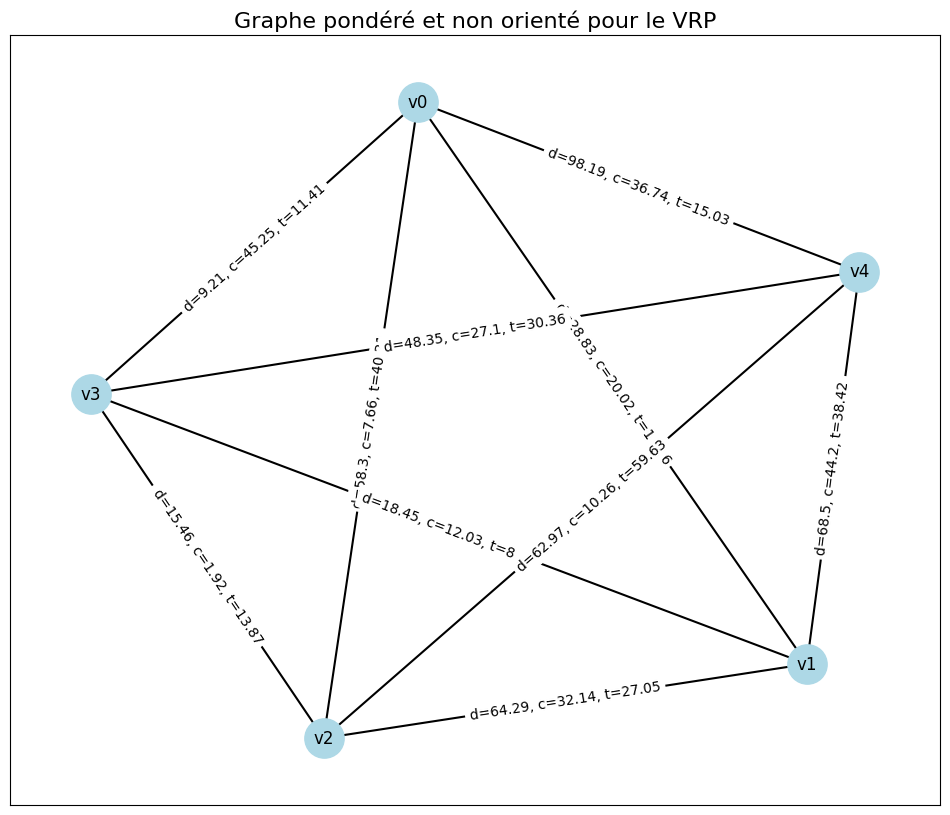

In [197]:
import matplotlib.pyplot as plt
import random
import networkx as nx

num_clients = 4 
depot = 0
nodes = [depot] + [i for i in range(1, num_clients + 1)]
G = nx.Graph()
for node in nodes:
    G.add_node(node)

for i in nodes:
    for j in nodes:
        if i < j:  
            distance = round(random.uniform(1, 100), 2)  
            cost = round(random.uniform(1, 50), 2)       
            time = round(random.uniform(1, 60), 2)     
            G.add_edge(i, j, distance=distance, cost=cost, time=time)

mapping = {node: f"v{node}" for node in G.nodes}
G = nx.relabel_nodes(G, mapping)
pos = nx.spring_layout(G, seed=42)  
plt.figure(figsize=(12, 10)) 
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.title("Graphe pondéré et non orienté pour le VRP", fontsize=16)
plt.show()


### Transformation du VRP en TSP

Pour transformer le VRP en TSP, **on crée 𝑘 copies du dépôt dans le graphe**. Ces copies représentent **les 𝑘 tournées distinctes du VRP**. En attribuant des coûts très élevés entre ces copies, on empêche le TSP de relier plusieurs dépôts dans une même boucle. Chaque copie devient ainsi le départ et l’arrivée d’une tournée spécifique, simulant l’utilisation de 𝑘 véhicules dans le TSP.
Plusieurs contraintes sont respectés pour les poids des aretes
- Les distances entre les clients sont conservées
- Les distances entre les copies du dépôt sont fixées à **une grande valeur 𝑀** pour décourager le passage direct entre ces copies
-Les distances entre chaque copie du dépôt $v_0^{(i)}$ et les clients sont égales à celles du dépôt original $v_0$ dans l’instance VRP.


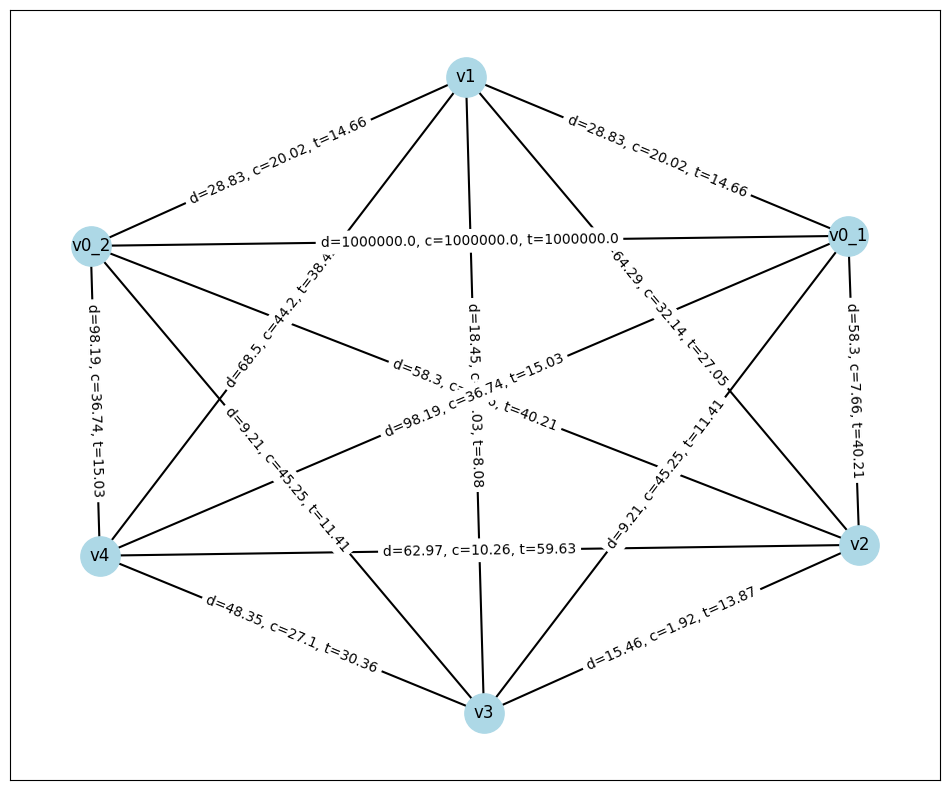

In [198]:
nombre_camion = 2
for i in range(1, nombre_camion + 1):
    depot_copy = f"v0_{i}"
    G.add_node(depot_copy)
    for node in G.nodes:
        if node != depot_copy and not node.startswith("v0_"):  
            original_edge = G.get_edge_data("v0", node)
            if original_edge:
                G.add_edge(depot_copy, node, **original_edge)

for i in range(1, nombre_camion + 1):
    for j in range(i + 1, nombre_camion + 1):
        G.add_edge(f"v0_{i}", f"v0_{j}", distance=1e6, cost=1e6, time=1e6)

if G.has_node("v0"):
    G.remove_node("v0")

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
edge_labels = {
    (u, v): f"d={data['distance']}, c={data['cost']}, t={data['time']}"
    for u, v, data in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
plt.show()

###  Conclusion sur la complexité du VRP

Le **Vehicle Routing Problem (VRP)** est une **généralisation** du **problème du voyageur de commerce (TSP)**.

Nous avons montré qu’une instance de VRP peut être transformée en une instance **équivalente de TSP en temps polynomial**, notamment en **dupliquant le dépôt** et en **modifiant les coûts** du graphe.

Or, le **TSP est un problème NP-complet**, ce qui signifie qu’il **n’existe pas d’algorithme polynomial connu** permettant de le résoudre efficacement dans tous les cas.

Cette réduction polynomiale montre donc que le VRP est lui aussi **NP-complet**, car **il est au moins aussi complexe que le TSP**.


### Génération des instances aléatoires

In [199]:
def generate_weight(restricted_edge, weight_range):
    if random.random() < restricted_edge: time = 999
    else: time = random.randint(*weight_range)
    if random.random() < restricted_edge: distance = 999
    else: distance = random.randint(*weight_range)
    if random.random() < restricted_edge: cost = 999
    else: cost = random.randint(*weight_range)
    return time, distance, cost

def generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=None):
    if seed is not None:
        random.seed(seed)
        
    G = nx.complete_graph(n)

    # Ajouter des poids aléatoires aux arêtes
    for u, v in G.edges():
        time, distance, cost = generate_weight(restricted_edge, weight_range)
        G[u][v]['time'] = time
        G[u][v]['distance'] = distance
        G[u][v]['cost'] = cost
    
    return G

In [200]:
def draw_graph(G):
    pos = nx.spring_layout(G)
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        time = data.get('time')
        distance = data.get('distance')
        cost = data.get('cost')
        edge_labels[(u, v)] = f"T:{time}, D:{distance}, C:{cost}"
    
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=250, font_size=7)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.show()

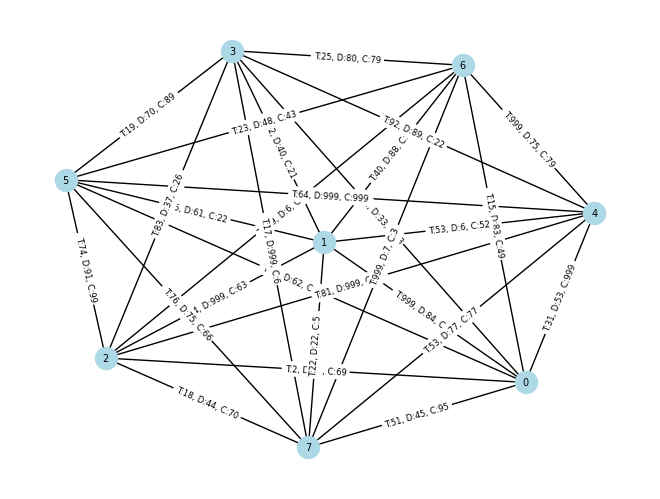

In [201]:
n = 8
G = generate_graph(n, weight_range=(1, 100), restricted_edge=0.1, seed=seed)
draw_graph(G)

# Modélisation linéaire du problème de tournées de véhicules pour minimiser la distance (VRP)

Ce modèle linéaire permet de résoudre un problème de tournées de véhicules, où plusieurs camions partent d’un dépôt, visitent des clients, puis reviennent au dépôt.  
L’objectif est de **minimiser la distance totale parcourue** tout en respectant certaines contraintes.
##  Données du problème

Le système est modélisé par un **graphe orienté pondéré** $G = (V, E)$ :

- $V = \{v_0, v_1, ..., v_n\}$ : ensemble des sommets, représentant les clients à visiter.  
- $v_0$ désigne le **dépôt** (point de départ et d’arrivée).
- $E \subseteq V \times V$ : ensemble des arêtes dirigées (routes).
- Chaque arête $(i, j) \in E$ est associée à une **distance** $d_{ij} \in \mathbb{R}^+$.
- $k$ : nombre de véhicules disponibles.


##  Variables de décision

- $x_{ij} \in \{0, 1\}$ : 1 si l’arête $(i, j)$ est empruntée par un véhicule, 0 sinon.

- $u_i \in \mathbb{Z}$ : variable auxiliaire pour éliminer les sous-tours (formulation MTZ), définie pour tous les $i \in \{1, ..., n\}$.



##  Fonction objectif

Minimiser la **distance totale parcourue** :

$$
\min \sum_{(i,j) \in E} d_{ij} \cdot x_{ij}
$$


##  Contraintes

### 1. Visite unique de chaque client

Chaque client doit être visité **exactement une fois** :

$$
\sum_{i \in V,\, i \ne j} x_{ij} = 1 \quad \forall j \in V 
$$

$$
\sum_{j \in V,\, j \ne i} x_{ij} = 1 \quad \forall i \in V 
$$


### 2. Utilisation du dépôt

Le dépôt $v_0$ est utilisé par exactement $k$ véhicules :

$$
\sum_{j \in V } x_{0j} = k
$$

$$
\sum_{i \in V} x_{i0} = k
$$



### 3. Élimination des sous-tours (MTZ)

Pour éviter la création de cycles ne passant pas par le dépôt :

$
1 \le u_i \le n \quad \forall i \in V 
$
$
u_i - u_j + n \cdot x_{ij} \le n - 1 \quad \forall i \ne j,\ i,j \in V
$

##  Interprétation

Ce modèle permet de :

- Planifier les tournées de $k$ véhicules partant et revenant au dépôt $v_0$
- Assurer la visite unique de chaque client
- Éviter les cycles internes sans passer par le dépôt
- **Minimiser la distance totale** pour un impact économique et écologique réduit

In [202]:
def solve_vrp_with_pl(graph, depot, num_vehicles):
    prob = LpProblem("Vehicle_Routing_Problem", LpMinimize)
    # Variables de décision
    x = LpVariable.dicts("x", [(i, j) for i in graph.nodes for j in graph.nodes if i != j], 0, 1, LpBinary)

    # Variables auxiliaires pour éliminer les sous-tours
    u = LpVariable.dicts("u", [i for i in graph.nodes if i != depot], 1, len(graph.nodes) - 1, LpContinuous)

   #fonction objectif
    prob += lpSum(graph[i][j]['distance'] * x[i, j] for i, j in x)
    #contraintes
    for j in graph.nodes:
        if j != depot:
            prob += lpSum(x[i, j] for i in graph.nodes if i != j) == 1
            prob += lpSum(x[j, i] for i in graph.nodes if i != j) == 1


    prob += lpSum(x[depot, j] for j in graph.nodes if j != depot) == num_vehicles
    prob += lpSum(x[j, depot] for j in graph.nodes if j != depot) == num_vehicles

    for i in graph.nodes:
        for j in graph.nodes:
            if i != j and i != depot and j != depot:
                prob += u[i] - u[j] + len(graph.nodes) * x[i, j] <= len(graph.nodes) - 1 #elimination des sous-tours

    
    prob.solve()

    # Extraction des résultats
    if LpStatus[prob.status] == "Optimal":
        print("Solution optimale trouvée !")
        # Construire les cycles pour chaque véhicule
        routes = []
        used_edges = [(i, j) for i, j in x if x[i, j].varValue > 0.5]

        for _ in range(num_vehicles):
            cycle = []
            current_node = depot
            while True:
                for edge in used_edges:
                    if edge[0] == current_node:
                        cycle.append(edge)
                        used_edges.remove(edge)
                        current_node = edge[1]
                        break
                if current_node == depot:
                    break
            routes.append(cycle)

        # Formater les cycles pour chaque véhicule
        formatted_routes = []
        for route in routes:
            formatted_routes.append([edge[0] for edge in route] + [depot])

        return formatted_routes, value(prob.objective)
    else:
        print("Aucune solution optimale trouvée.")
        return None, None



Solution optimale trouvée !
Routes optimisées : [[0, 2, 6, 7, 1, 4, 0], [0, 3, 0], [0, 5, 0]]
Distance totale : 335.0


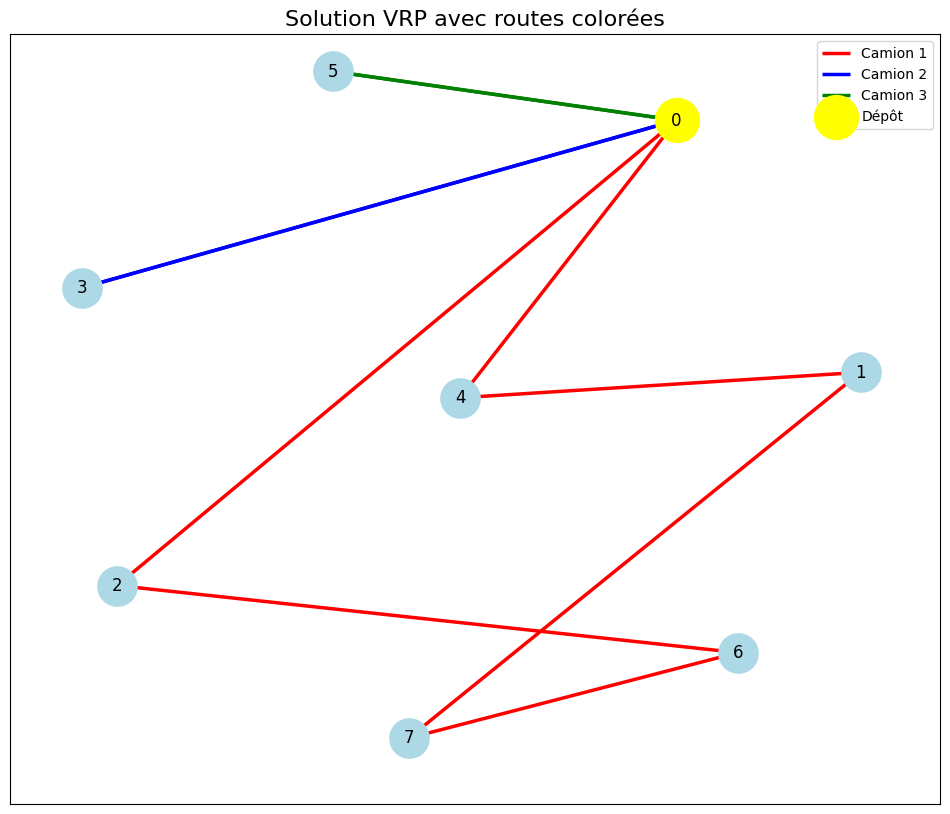

In [203]:
def plot_vrp_solution(graph, routes, depot):
    #dessiner le graphe
    pos = nx.spring_layout(graph, seed=42)  
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] 
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(graph, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')
    
    #dessiner les arêtes
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]  
        edges = [(route[j], route[j + 1]) for j in range(len(route) - 1)]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, width=2.5, edge_color=color, label=f'Camion {i + 1}')
    nx.draw_networkx_nodes(graph, pos, nodelist=[depot], node_size=1000, node_color='yellow', label='Dépôt')
    plt.title("Solution VRP avec routes colorées", fontsize=16)
    plt.legend()
    plt.show()
# Résoudre le VRP grâce à la programmation linéaire
routes, total_distance = solve_vrp_with_pl(G, depot=0, num_vehicles=3)
# Afficher les résultats
if routes:
    print("Routes optimisées :", routes)
    print("Distance totale :", total_distance)
    plot_vrp_solution(G, routes, depot=0)

In [204]:
def robust_vrp_tabou(graph, depot, num_vehicles):
    nodes = list(graph.nodes())
    nodes.remove(depot)
    random.shuffle(nodes)
    split = [nodes[i::num_vehicles] for i in range(num_vehicles)]
    current = [[depot] + route + [depot] for route in split]
    best = copy.deepcopy(current)

    def cost(sol):
        # Calcul du coût total des trajets pour tous les véhicules
        return sum(sum(graph[r[i]][r[i+1]]['weight'] for i in range(len(r)-1)) for r in sol)

    best_cost = cost(best)
    tabu, tenure = [], 10

    for _ in range(500):  # Nombre d'itérations
        neighborhood = []
        for _ in range(100):  # Nombre de voisins à générer
            n = copy.deepcopy(current)
            a, b = random.sample(range(num_vehicles), 2)
            if len(n[a]) > 2 and len(n[b]) > 2:
                # Échanger des clients entre les deux véhicules
                i, j = random.randint(1, len(n[a])-2), random.randint(1, len(n[b])-2)
                # Échanger les clients dans les routes a et b
                move = (n[a][i], n[b][j])
                n[a][i], n[b][j] = n[b][j], n[a][i]
                neighborhood.append((n, move))

        best_n, best_n_cost = None, float('inf')
        for n, m in neighborhood:
            # Si le mouvement n'est pas dans la liste tabou, on l'évalue
            if m not in tabu:
                c = cost(n)
                if c < best_n_cost:
                    best_n, best_n_cost, best_move = n, c, m

        # Si on a trouvé une meilleure solution, on met à jour
        if best_n:
            current = best_n
            tabu.append(best_move)
            if len(tabu) > tenure:
                tabu.pop(0)
            if best_n_cost < best_cost:
                best, best_cost = copy.deepcopy(current), best_n_cost

    return best

In [ ]:
depot = 0
num_vehicles = 2  # Un seul véhicule

solution = robust_vrp_tabou(G, depot, num_vehicles)

for idx, route in enumerate(solution):
    print(f"Véhicule {idx+1} : {route}")

KeyError: 'weight'

In [ ]:
def robust_vrp(graph, depot):
    unvisited = set(graph.nodes())
    unvisited.remove(depot)
    routes = []

    while unvisited:
        current_route = [depot]
        visited_this_trip = set()


        reachable = [node for node in unvisited if nx.has_path(graph, depot, node)]
        if not reachable:
            start = unvisited.pop()
            current_route = [start]
            visited_this_trip.add(start)
        else:
            closest = min(reachable, key=lambda node: nx.shortest_path_length(graph, depot, node, weight='weight'))
            path = nx.shortest_path(graph, depot, closest, weight='weight')
            current_route += path[1:]
            visited_this_trip.update(path[1:])
            unvisited -= set(path[1:])

        current = current_route[-1]

        while True:
            next_nodes = [n for n in graph.neighbors(current) if n in unvisited]
            if not next_nodes:
                break
            next_node = min(next_nodes, key=lambda x: graph[current][x]['weight'])
            current_route.append(next_node)
            visited_this_trip.add(next_node)
            unvisited.remove(next_node)  
            current = next_node
        if current != depot and nx.has_path(graph, current, depot):
            back_path = nx.shortest_path(graph, current, depot, weight='weight')
            current_route += back_path[1:]

        routes.append(current_route)

    return routes

In [ ]:
routes = robust_vrp(G, depot)

print("\n🚚 Tournées optimisées :")
for i, route in enumerate(routes):
    print(f"Camion {i+1} : {' -> '.join(map(str, route))}")


🚚 Tournées optimisées :
Camion 1 : 0 -> 3 -> 8 -> 4 -> 7 -> 5 -> 2 -> 10 -> 9 -> 1 -> 6 -> 3 -> 0


### Méta heuristique
Nous avons fait le choix d'utiliser deux méta heuristiques pour résoudre notre problème de tournées de véhicules. Ces deux algorithmes sont les suivants :
- **la colonie de fourmis** : qui s'inspire du comportement des fourmis pour trouver le chemin le plus court entre le dépôt et les clients.
- **la recherche tabou** : qui utilise une mémoire pour éviter de revisiter les solutions déjà explorées, permettant ainsi d'explorer efficacement l'espace de recherche.

In [ ]:
from copy import deepcopy


def tabu_vrp(graph, depot, max_iter=100, tabu_tenure=10):
    unvisited = set(graph.nodes())
    unvisited.remove(depot)
    routes = []

    # Génération de la solution initiale
    while unvisited:
        route = [depot]
        current = depot
        while True:
            next_nodes = [n for n in graph.neighbors(current) if n in unvisited]
            if not next_nodes:
                break
            next_node = min(next_nodes, key=lambda x: graph[current][x]['weight'])
            route.append(next_node)
            unvisited.remove(next_node)
            current = next_node
        if current != depot and nx.has_path(graph, current, depot):
            back_path = nx.shortest_path(graph, current, depot, weight='weight')
            route += back_path[1:]
        routes.append(route)

    current_solution = deepcopy(routes)
    best_solution = deepcopy(current_solution)
    best_cost = sum(
        sum(graph[route[i]][route[i + 1]]['weight'] for i in range(len(route) - 1))
        for route in best_solution
    )
    tabu_list = []

    for _ in range(max_iter):
        neighbors = []

        for r1 in range(len(current_solution)):
            for r2 in range(len(current_solution)):
                if r1 != r2:
                    for i in range(1, len(current_solution[r1]) - 1):
                        for j in range(1, len(current_solution[r2]) - 1):
                            move = ((r1, i), (r2, j))
                            if move in tabu_list:
                                continue
                            new_r1 = current_solution[r1][:]
                            new_r2 = current_solution[r2][:]
                            new_r1[i], new_r2[j] = new_r2[j], new_r1[i]
                            new_routes = deepcopy(current_solution)
                            new_routes[r1] = new_r1
                            new_routes[r2] = new_r2
                            cost = sum(
                                sum(graph[route[k]][route[k + 1]]['weight'] for k in range(len(route) - 1))
                                for route in new_routes
                            )
                            neighbors.append((new_routes, move, cost))

        if not neighbors:
            break

        neighbors.sort(key=lambda x: x[2])
        best_neighbor, best_move, best_neighbor_cost = neighbors[0]
        current_solution = best_neighbor

        if best_neighbor_cost < best_cost:
            best_solution = deepcopy(best_neighbor)
            best_cost = best_neighbor_cost

        tabu_list.append(best_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

    return best_solution


### Références utiles

- https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_voyageur_de_commerce
- https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_tourn%C3%A9es_de_v%C3%A9hicules
- Workshop
- https://networkx.org/documentation/stable/reference/introduction.html
- https://www.guru99.com/fr/travelling-salesman-problem.html#:~:text=Le%20probl%C3%A8me%20du%20voyageur%20de%20commerce%20%28TSP%29%20est,fa%C3%A7on%20exponentielle%20avec%20l%E2%80%99augmentation%20du%20nombre%20de%20villes.
- https://github.com/jwang0306/vehicle-routing-problem?tab=readme-ov-file
- https://www.youtube.com/watch?v=GiDsjIBOVoA&list=TLPQMjcwNDIwMjWGmE-QXy8F6w&index=1&pp=gAQBiAQB